# OCR(Optical Character Recognition)
OCR is the technology that converts images of text into machine-readable text.


Main challenges:
 - Variable text sizes and styles
 - Different character spacing
 - No clear character boundaries
 - Text distortion and noise
 - Sequence alignment issues


Traditional vs Modern OCR Approaches:

Traditional:

1. Character segmentation
2. Individual character recognition
3. Post-processing


Modern (Deep Learning):

1. Feature extraction using CNNs
2. Sequence processing using RNNs
3. End-to-end training without explicit segmentation






In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import os 
from pathlib import Path

## Load Data

In [2]:
# !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
# !unzip -qq captcha_images_v2.zip

The dataset contains 1040 captcha files as `png` images. The label for each sample is a string,
the name of the file (minus the file extension).
We will map each character in the string to an integer for training the model. Similary,
we will need to map the predictions of the model back to strings. For this purpose
we will maintain two dictionaries, mapping characters to integers, and integers to characters,
respectively.

In [3]:
data_dir = Path('./captcha_images_v2')

# Get List of All Images
images = sorted(list(map(str,list(data_dir.glob(pattern='*.png')))))
print(images[:5])

# Get List of All Labels
labels = [img.split(os.path.sep)[-1].replace('.png', '') for img in images]
print(labels[:5])

# Get List of All Characters 
characters = sorted(list(set(char for label in labels for char in label)))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

['captcha_images_v2/226md.png', 'captcha_images_v2/22d5n.png', 'captcha_images_v2/2356g.png', 'captcha_images_v2/23mdg.png', 'captcha_images_v2/23n88.png']
['226md', '22d5n', '2356g', '23mdg', '23n88']
Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [4]:
batch_size = 16
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4 

max_length = max([len(label) for label in labels])
max_length

5

## Pre-Processing

In [5]:
# Mapping Characters to Integers
char_to_num = tf.keras.layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping Integers back to Original Characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

2025-01-09 21:39:28.864483: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-09 21:39:28.864518: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-09 21:39:28.864522: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-09 21:39:28.864821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-09 21:39:28.864845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
def split_data(images, labels, train_size=0.9, shuffle=True): 
    size = len(images)
    indices = tf.keras.ops.arange(size)
    
    if shuffle: 
        indices = tf.keras.random.shuffle(indices)

    train_samples = int(size * train_size)

    X_train, Y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_val, y_val = images[indices[train_samples:]], labels[indices[train_samples:]]

    return X_train, Y_train, x_val, y_val


In [7]:
X_train, Y_train, x_val, y_val = split_data(np.array(images), np.array(labels))

In [8]:
indices = tf.keras.ops.arange(100)
print(indices)
indices = tf.keras.random.shuffle(indices)
print(indices)
sample = int(100*0.9)
print(sample)

indices[sample:]

tf.Tensor(
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99], shape=(100,), dtype=int32)
tf.Tensor(
[81  1 35 28 72 23 37 50 94  8 62 74 53  4 17 20 98 64 96 11 51 24 78 63
 97  5 10 66 18 77 54 90 38 41 93 21 91 14 75 58 95 85 33 55 99 16 15 12
 80 61 71 49 26 47 57 52 73 48  3 45 29 83 59 42 56 44  6 31 46  2 92 19
 34 13 79 36 22 25 27  7 76 70 30 86 67 32 84 40 65 39 43 87 88 89 68  9
 60 82  0 69], shape=(100,), dtype=int32)
90


<tf.Tensor: shape=(10,), dtype=int32, numpy=array([43, 87, 88, 89, 68,  9, 60, 82,  0, 69], dtype=int32)>

In [9]:
img = tf.io.read_file(images[0])

img = tf.image.decode_png(img, channels=1)

img = tf.image.convert_image_dtype(img, tf.float32)

img = tf.keras.ops.image.resize(img, [img_height, img_width])
print(img.shape)

img = tf.keras.ops.transpose(img, axes=[1,0,2])
print(img.shape)

label  = char_to_num(tf.strings.unicode_split('ax3h9k',input_encoding='UTF-8'))

print(label.numpy())


(50, 200, 1)
(200, 50, 1)
[ 0 18  2  0  0  0]


In [10]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)

    img = tf.image.decode_png(img, channels=1)

    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.keras.ops.image.resize(img, [img_height, img_width])

    img = tf.keras.ops.transpose(img, axes=[1,0,2])

    label  = char_to_num(tf.strings.unicode_split(label,input_encoding='UTF-8'))

    return {'image': img, 'label': label}

## Create Datasets

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = ( 
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = ( 
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualizing Captchas

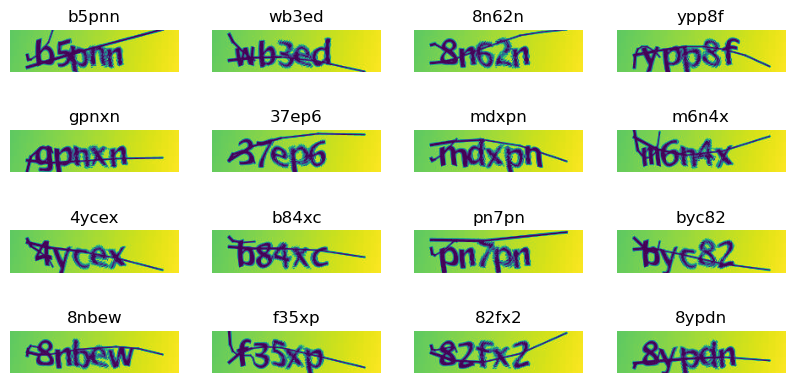

2025-01-09 21:39:31.156468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
fig, ax = plt.subplots(4,4,figsize=(10, 5))

for batch in train_dataset.take(1):
    images = batch['image']
    labels = batch['label']
    for index, image in enumerate(images): 
        img = (image*255).numpy().astype('uint8')
        label = tf.strings.reduce_join(num_to_char(labels[index])).numpy().decode('utf-8')
        ax[index//4, index%4].imshow(img[:,:,0].T)
        ax[index//4, index%4].set_title(label)
        ax[index//4, index%4].axis('off')

    plt.show()

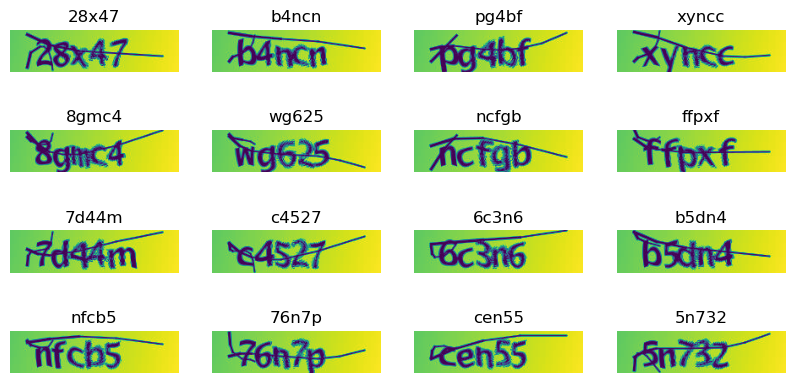

2025-01-09 21:39:31.807437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
fig, ax = plt.subplots(4,4,figsize=(10, 5))

for batch in train_dataset.skip(1).take(2):
    images = batch['image']
    labels = batch['label']
    for index, image in enumerate(images): 
        img = (image*255).numpy().astype('uint8')
        label = tf.strings.reduce_join(num_to_char(labels[index])).numpy().decode('utf-8')
        ax[index//4, index%4].imshow(img[:,:,0].T)
        ax[index//4, index%4].set_title(label)
        ax[index//4, index%4].axis('off')

    plt.show()

## Model

### Define Custom Loss Function

CTC (Connectionist Temporal Classification):

Problem it solves:

- In OCR, we don't know exact alignment between image regions and characters
- Example: Image "hello" → We don't know which pixels correspond to 'h', 'e', etc.


How CTC works:

- Allows multiple valid alignments between input and output
- Introduces blank token (−) for spacing
- Merges repeated characters
- Example: `Input sequence: hh−ee−ll−ll−oo,
After CTC: hello`


In [14]:
def ctc_label_dense_to_sparse(labels, label_lengths):
    """ 
    Purpose: 
           - CTC needs sparse representation for efficiency
           - Converts dense labels to sparse format
    """

    # Get Shape Information from input labels
    label_shape = tf.shape(labels)
    num_batches_tns = tf.stack([label_shape[0]])
    max_num_labels_tns = tf.stack([label_shape[1]])

    # def range_less_than(old_input, curr_input):
    #     """
    #     Helper Function to create mask for valid label positions
    #     """ 

    #     # Get the width of the old input
    #     old_input_width = tf.shape(old_input)[1]
    #     # Create a range from 0 to old_input
    #     range_tensor = tf.keras.ops.arange(old_input_width)
    #     # Add an extra dimension at index 0 to make it 2D
    #     expanded_range = tf.expand_dims(range_tensor, 0)
    #     # Create a tensor filled with curr_input value
    #     comparison_tensor = tf.fill(max_num_labels_tns, curr_input)

    #     # Compare each element in expanded_range with comparison_tensor
    #     # Returns a boolean tensor where True indicates range value is less than current_input
    #     result = expanded_range < comparison_tensor
    #     return result
    
    def range_less_than(old_input, current_input):
        return tf.keras.ops.expand_dims(tf.keras.ops.arange(tf.keras.ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )
    
    # Initialize and create Dense mask
    # Initialize with zeros
    init = tf.cast(tf.fill([1, label_shape[1]], 0), dtype='bool')

    # Creates mask for each sequence using scan operation
    dense_mask = tf.scan( 
        range_less_than, 
        label_lengths, 
        initializer=init, 
        parallel_iterations=1
    )

    dense_mask = dense_mask[:,0,:]
    
    # Create indices for labels
    label_array = tf.reshape(tf.tile(tf.keras.ops.arange(0, label_shape[1]), num_batches_tns), label_shape)
    # Apply mask to get valid label indices
    label_indices = tf.boolean_mask(label_array, dense_mask)

    # Create batch indices
    batch_array = tf.transpose(
        tf.reshape(
            tf.tile(tf.keras.ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    # Apply mask to get valid batch indices
    batch_indices = tf.boolean_mask(batch_array, dense_mask)

    # Combine Indices and create SparseTensor
    # Combine batch and label indices
    indices = tf.transpose(
        tf.reshape(tf.concat([batch_indices, label_indices], axis=0), [2, -1])
    )

    # Get the actual values from labels using indices
    vals_sparse = tf.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.cast(indices, dtype='int64'), 
        vals_sparse, 
        tf.cast(label_shape, dtype='int64')
    )

In [15]:
tf.cast(tf.fill([1, 40], 0), dtype='bool')

<tf.Tensor: shape=(1, 40), dtype=bool, numpy=
array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False]])>

In [16]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    """ 
    Purpose: 
           - Calculates probability of all possible alignments
           - Finds Optimal path bw prediction and true_values
    """ 

    # Convert label_length and input_length to int32 and remove extra dimensions
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), dtype='int32')
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), dtype='int32')

    # Convert Dense Labels to sparse format required by CTC Loss
    sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), dtype='int32')

    # Add epsilon(small value) to predictions to avoid log(0) errors
    # Time predictions to time-major format required by CTC Loss
    y_pred = tf.keras.ops.log(tf.transpose(y_pred, perm=[1, 0, 2]) + tf.keras.backend.epsilon())

    # Calculate CTC Loss using Tensorflow`s built-in function
    loss = tf.compat.v1.nn.ctc_loss(
        inputs=y_pred, 
        labels=sparse_labels, 
        sequence_length=input_length
    )
    loss = tf.expand_dims(loss, 1)

    return loss

In [17]:
class CTCLayer(tf.keras.layers.Layer): 
    """
    Purpose:
           - Integrates CTC loss into model architecture
           - Handles Length Calculations
           - Manages Loss during Training
    """
    def __init__(self, name=None): 
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred): 
        batch_length = tf.cast(tf.shape(y_true)[0], dtype='int64')
        # Calculate input and label lengths
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')
        # Create tensors of input and label lengths for each item in batch
        input_length = input_length * tf.ones(shape=(batch_length, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_length, 1), dtype='int64')

        # Calculate CTC Loss
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred # return predictions for inferenceep

### Build Model

In [18]:
input_img = tf.keras.layers.Input(shape=(img_width, img_height, 1), name='image', dtype='float32')
labels = tf.keras.layers.Input(name='label', shape=(None,), dtype='float32' )

x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal",padding="same")(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)


x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal",padding="same")(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Reshape layer to prepare for RNN
# Feature maps are 4x smaller due to two max pooling layers
new_shape = (img_width // 4, (img_height // 4) * 64)
x = tf.keras.layers.Reshape(target_shape=new_shape, name='reshape')(x)

x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)


# Bidirectional LSTM layers
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# Output dense layer with softmax activation
x = tf.keras.layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation='softmax', )(x)

# Add CTC Layer for loss calculation
output = CTCLayer()(labels, x)

In [19]:
model = tf.keras.Model(inputs=[input_img, labels], outputs=output, name='ocr_model')

In [20]:
model.summary()

Model: "ocr_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 50,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 100, 25,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 25,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 50, 12,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 768)   │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50, 21)    │      2,709 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_layer           │ (None, 50, 21)    │          0 │ label[0][0],      │
│ (CTCLayer)          │                   │            │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam())

In [22]:
early_stopping_patience = 10

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

In [23]:
hist = model.fit(train_dataset, validation_data=validation_dataset, epochs=100, callbacks=[early_stopping])

Epoch 1/100


2025-01-09 21:39:36.171153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - loss: 637.5264 - val_loss: 253.2489
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - loss: 262.5047 - val_loss: 251.5091
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - loss: 262.0124 - val_loss: 251.9202
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - loss: 261.7440 - val_loss: 251.5182
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - loss: 261.7784 - val_loss: 251.6412
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - loss: 261.6872 - val_loss: 251.6096
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - loss: 261.6346 - val_loss: 251.2430
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - loss: 261.3647 - val_loss: 250.9642
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - loss: 261.3306 - val_loss: 251.3077
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - loss: 261.2954 - val_loss: 250.9562
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 237ms/step - loss: 260.8910 - val_loss: 250.738

In [38]:
def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = tf.keras.ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = tf.keras.ops.log(tf.keras.ops.transpose(y_pred, axes=[1, 0, 2]) + tf.keras.backend.epsilon())
    input_length = tf.keras.ops.cast(input_length, dtype="int32")

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)

In [35]:
model.layers

[<InputLayer name=image, built=True>,
 <Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Reshape name=reshape, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Bidirectional name=bidirectional, built=True>,
 <Bidirectional name=bidirectional_1, built=True>,
 <InputLayer name=label, built=True>,
 <Dense name=dense_1, built=True>,
 <CTCLayer name=ctc_layer, built=True>]

The reason for creating a separate prediction model has to do with how OCR models using CTC (Connectionist Temporal Classification) work. Let me explain:

1. Training Model vs. Prediction Model:


- Our training model has two inputs:

   1. The image input (model.input[0])
   2. The label input (model.input[1] or the "label" InputLayer)


- It also uses a CTC loss layer for training

2. During Training:
   #### Training model needs:
     - Image input → Convolutional layers → Bidirectional LSTM → Dense layer
     - Label input
     - CTC layer to compute loss and train the network 

3. During Prediction/Inference:
   #### You only need:
      - Image input → Convolutional layers → Bidirectional LSTM → Dense layer
   #### You don't need:
      - Label input (since you don't have ground truth during prediction)
      - CTC layer (since you're not computing loss anymore)


That's why you create a prediction model that:

Takes only the image input (model.input[0])
Outputs the character probabilities from the dense layer (model.get_layer(name="dense_1").output)
Excludes the CTC layer and label input


In [30]:
prediction_model = tf.keras.models.Model(
    model.input[0], model.get_layer(name="dense_1").output
)
prediction_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 768)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50, 64)         │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50, 21)         │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


2025-01-09 22:27:00.857828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


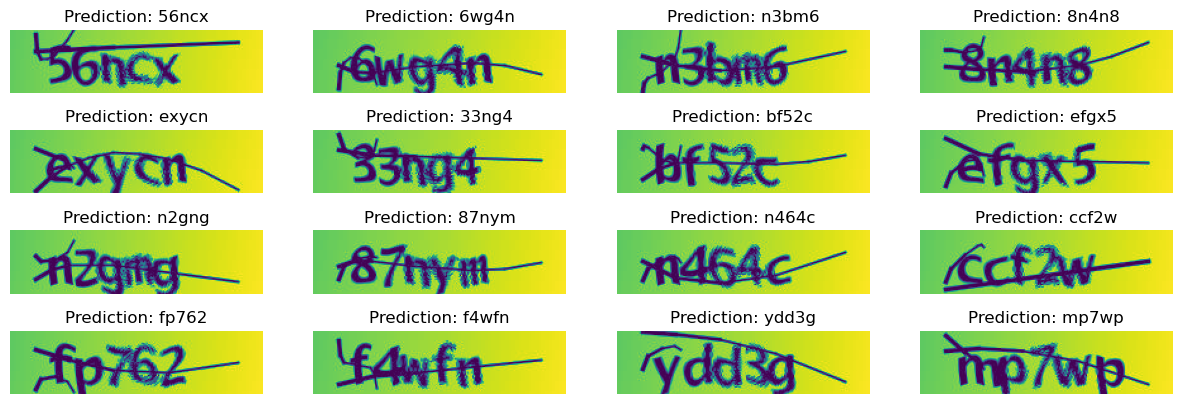

In [43]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()